In [1]:
#!/usr/bin/env python3

In [2]:
%matplotlib inline
import numpy as np 
import time 
from datetime import timedelta
import tensorflow as tf
from readImages import *
from build_tensorflow_graph import *
import matplotlib.pyplot as plt
import joblib
import random

In [3]:
def nextEpoch(imgs, batch_size = 128):
    imgs = random.sample(imgs, len(imgs))
    
    numBatches = len(imgs) // batch_size
    for i in range(numBatches):
        yield imgs[i*batch_size : (i+1)*batch_size]

In [4]:
#
## ---------- DCGAN Architecture ----------
#

numFilters1 = 32
numFilters2 = 64 
numFilters3 = 128
numFilters4 = 256

pooling_size = None
strides = 2
# Convolution Layer 1
cnnArchitecture1 = CNN_Architecture(numFilters = numFilters1, 
                                    filterSize = (5, 5), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = 3, 
                                    maxPoolingSize=pooling_size)

dcnnArchitecture1 = CNN_Architecture(numFilters = 3, 
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = False, 
                                    numInputChannels = numFilters1, 
                                    maxPoolingSize=pooling_size)

# Convolution Layer 2
cnnArchitecture2 = CNN_Architecture(numFilters = numFilters2, 
                                    filterSize = (5, 5), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters1, 
                                    maxPoolingSize=pooling_size)
dcnnArchitecture2 = CNN_Architecture(numFilters = numFilters1, 
                                    filterSize = (3, 3), 
                                    strides = strides,
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters2, 
                                    maxPoolingSize=pooling_size)

# Convolution Layer 3
cnnArchitecture3 = CNN_Architecture(numFilters = numFilters3,
                                    filterSize = (5, 5), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters2, 
                                    maxPoolingSize=pooling_size)
dcnnArchitecture3 = CNN_Architecture(numFilters = numFilters2,
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters3, 
                                    maxPoolingSize=pooling_size)

# Convolution Layer 4
cnnArchitecture4 = CNN_Architecture(numFilters = numFilters4,
                                    filterSize = (5, 5), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters3, 
                                    maxPoolingSize=pooling_size)
dcnnArchitecture4 = CNN_Architecture(numFilters = numFilters3,
                                    filterSize = (3, 3), 
                                    strides = strides, 
                                    toPadding = True, 
                                    useReLU = True, 
                                    numInputChannels = numFilters4, 
                                    maxPoolingSize=pooling_size)

# Fully Connected 1
fc5_size = 1024 

# Lattern Code 
z_dim = 512

# flattern size
flat_size = 4096

In [5]:
class Image:
    size = 64
    channels = 3

<div>
<h1>Network Output Size</h1>
    <p>
    <ul>
        <li>Input Layer: 64 * 64 * 3 = 12288</li>
        <li>Convolutional Layer1: 32 * 32 * 32 = 32768 </li>
        <li>Convolutional Layer2: 16 * 16 * 64 = 16384 </li>
        <li>Convolutional Layer3: 8 * 8 * 128 = 8192 </li>
        <li>Convolutional Layer4: 4 * 4 * 256 = 4096 </li>
        <li>Fully Connected Layer5: 1024 </li>
        <li>Latten Code: 256 </li>
    </ul>
    </p>
</div>


In [6]:
class LSGAN:
    """
    """
    def __init__(self, batch_size, lr_g=1e-3, lr_d=1e-4):
        self.lr_g = lr_g
        self.lr_d = lr_d
        self.batch_size = batch_size
        self.sess = tf.Session()
        
        self.build_model()
        
    def mse_loss(self, layer1, layer2):
        loss = (2 * tf.nn.l2_loss(layer1 - layer2)) / self.batch_size
#         loss = tf.reduce_sum(tf.square(layer1 - layer2), axis = 1)
        
        return loss
    
    def build_model(self):
        # ---------- 1. placeholder ----------
        self.lattenCode = tf.placeholder(tf.float32, shape = [None, z_dim])
        self.inputImages = tf.placeholder(tf.float32, shape = [None, Image.size, Image.size, Image.channels])
        
        # ---------- 2. Discriminator & generator ----------
        self.discriminate_true = self.build_discriminator(self.inputImages, is_training = True, 
                                                          reuse = False, init_stdev = 0.01)
        
        self.generatedImgs = self.build_generator(self.lattenCode, is_training = True, bs = self.batch_size, 
                                                  reuse = False, init_stdev = 0.01)
        
        self.discriminate_fake = self.build_discriminator(self.generatedImgs, is_training = True, 
                                                         reuse = True, init_stdev = 0.01)
        # ---------- 3. Cost Function & Optimizer ----------
        # Discriminator loss 
#         discriminator_true_loss = tf.reduce_mean(2*tf.nn.l2_loss(self.discriminate_true - tf.ones_like(self.discriminate_true)))
#         discriminator_fake_loss = tf.reduce_mean(2*tf.nn.l2_loss(self.discriminate_fake - tf.zeros_like(self.discriminate_fake)))
        discriminator_true_loss = tf.reduce_mean(self.mse_loss(self.discriminate_true, tf.ones_like(self.discriminate_true)))
        discriminator_fake_loss = tf.reduce_mean(self.mse_loss(self.discriminate_fake, tf.zeros_like(self.discriminate_fake)))
        self.discriminator_loss = (discriminator_true_loss + discriminator_fake_loss) * 0.5 
        
        
        # Generator Loss 
#         self.generator_loss = tf.reduce_mean(-tf.log(self.discriminate_fake))
#         self.generator_loss = tf.reduce_mean(2*tf.nn.l2_loss(self.discriminate_fake -tf.ones_like(self.discriminate_fake))) / self.batch_size
        self.generator_loss = 0.5*tf.reduce_mean(self.mse_loss(self.discriminate_fake, tf.ones_like(self.discriminate_fake)))
        # Optimizer 
        all_vars = tf.trainable_variables()
        d_vars = [var for var in all_vars if 'discriminator' in var.name]
        g_vars = [var for var in all_vars if 'generator' in var.name]
        
        ## For Testing
#         d_names = [v.name for v in d_vars]
#         g_names = [v.name for v in g_vars]
#         print('d_names:', d_names)
#         print('g_names', g_names)
        
        self.generator_optimizer = tf.train.AdamOptimizer(self.lr_g).minimize(self.generator_loss, var_list=g_vars)
        self.discriminator_optimizer = tf.train.AdamOptimizer(self.lr_d).minimize(self.discriminator_loss, var_list=d_vars)
        
        # ---------- 4. build Testing Model ----------
        self.numGenerates = 64
        self.fake_images = self.build_generator(self.lattenCode, is_training = False, reuse = True, 
                                                bs = self.numGenerates, init_stdev = 0.01)
        # --------- 5. Model Saver ----------
        self.saver = tf.train.Saver()
            
    def build_discriminator(self, inputLayer, is_training = True, reuse = False, init_stdev = 0.01):
        """
        Arg:
        -------------------------------------------------------------------------
          * inputLayer [tensor] shape = (batch, height, width, channel).
          
        """
        with tf.variable_scope("discriminator", reuse = reuse):
            # Convolutional Layers
            conv1, _ = new_convLayer(inputLayer, cnnArchitecture1, name = "dis_conv1", stdev = init_stdev)
            conv2, _ = new_convLayer(conv1, cnnArchitecture2, name = "dis_conv2", stdev = init_stdev)
            conv2 = bn(conv2, is_training = is_training, scope = "dis_bn2")
            conv3, _ = new_convLayer(conv2, cnnArchitecture3, name = "dis_conv3", stdev = init_stdev)
            conv3 = bn(conv3, is_training = is_training, scope = "dis_bn3")
            conv4, _ = new_convLayer(conv3, cnnArchitecture4, name = "dis_conv4", stdev = init_stdev)
            conv4 = bn(conv4, is_training = is_training, scope = "dis_bn4")
            
#             ## for testing
#             _, nodes1 = flattenLayer(conv1)
#             _, nodes2 = flattenLayer(conv2)
#             _, nodes3 = flattenLayer(conv3)
#             _, nodes4 = flattenLayer(conv4)
#             nodess = [nodes1, nodes2, nodes3, nodes4]
#             for i in range(1, 5): 
#                 print('#nodes in conv{}: {}'.format(i, nodess[i - 1]))
            
            # Flattern
            flat, numNodes = flattenLayer(conv4)
#             assert numNodes == flat_size, "Something wrong while flatterning ... {} != {}".format(numNodes, flat_size)
            self.flat_size = numNodes
            
            # Fully Connected Layers
            fc5 = new_fcLayer(flat, numNodes, fc5_size, useReLU=True, name="dis_fc5", stdev=init_stdev)
            fc5 = bn(fc5, is_training = is_training, scope = "dis_bn5")
            output = new_fcLayer(fc5, fc5_size, 1, useReLU=False, name="dis_out", stdev=init_stdev)
#             output = tf.nn.sigmoid(output)
            
            return output
            
    
    def build_generator(self, inputLayer, is_training = True, bs = None, reuse = False, init_stdev = 0.01):
        if bs is None:
            bs = self.batch_size
        if strides > 1: 
            to_unpool = False
        else:
            to_unpool = True
            
        with tf.variable_scope("generator", reuse = reuse):
            # de fully connected layers
            fc1 = new_fcLayer(inputLayer, z_dim, fc5_size, useReLU=True, name="gen_fc1", stdev=init_stdev)
            fc1 = bn(fc1, is_training = is_training, scope = "gen_bn1")
            fc2 = new_fcLayer(fc1, fc5_size, self.flat_size, useReLU=True, name="gen_dconv2", stdev=init_stdev)
            fc2 = bn(fc2, is_training = is_training, scope = "gen_bn2")
            
            # Reshaping
            conv2 = tf.reshape(fc2, shape=[-1, 4, 4, numFilters4])
            
            # Convolutional Layers
            if to_unpool: conv2 = unpool(conv2, kernel=(2, 2))
            conv3 = new_dconvLayer(conv2, dcnnArchitecture4, outputShape = [bs, Image.size // 8, Image.size // 8, numFilters3], 
                                   name = "gen_dconv3", stdev = init_stdev)
            conv3 = bn(conv3, is_training = is_training, scope = "gen_bn3")
            
            if to_unpool: conv3 = unpool(conv3, kernel=(2, 2))
            conv4 = new_dconvLayer(conv3, dcnnArchitecture3, outputShape = [bs, Image.size // 4, Image.size // 4, numFilters2], 
                                   name = "gen_dconv4", stdev = init_stdev)
            conv4 = bn(conv4, is_training = is_training, scope = "gen_bn4")
            
            if to_unpool: conv4 = unpool(conv4, kernel=(2, 2))
            conv5 = new_dconvLayer(conv4, dcnnArchitecture2, outputShape = [bs, Image.size // 2, Image.size // 2, numFilters1], 
                                   name = "gen_dconv5", stdev = init_stdev)
            conv5 = bn(conv5, is_training = is_training, scope = "gen_bn5")
            
            if to_unpool: conv5 = unpool(conv5, kernel=(2, 2))
            image = new_dconvLayer(conv5, dcnnArchitecture1, outputShape = [bs, Image.size, Image.size, Image.channels], 
                                   name = "gen_image", stdev = init_stdev)
            image = tf.nn.sigmoid(image)
            
            return image
            
            
    def train(self, fileDir, epochs = 100, saveModel = False, k = 1, restorePath=None, monitor=0):
        generator_lossHistory = []
        discriminator_lossHistory = []
        
        print('  * Start Training {:>3} epochs ...'.format(epochs))
        if not restorePath:
            print('\t- initializing network ...')
            self.sess.run(tf.global_variables_initializer())
        else:
            self.saver.restore(self.sess, restorePath)
            print("\t- model '{}' restored.".format(restorePath))
        
        all_imgs = joblib.load('../all_images.pkl')
        for epoch in range(epochs):
            print('    * processing epoch #{} '.format(epoch+1))
            count = 0
#             for batch in readImagesIn(directory=fileDir, size=(Image.size, Image.size),
#                                            noiseStdev=0.0, batch_size = (self.batch_size)*k ):
            for batch in nextEpoch(all_imgs, batch_size = (self.batch_size)*k):
                count += 1
                # ----------- Train Discriminator k times ----------
                for i in range(k):
                    batch_imgs = batch[i*self.batch_size :(i+1)*self.batch_size]
                    batch_z = np.random.normal(0, 1, [self.batch_size, z_dim])
                    
                    feed_dict_discriminator = {self.lattenCode : batch_z, self.inputImages : batch_imgs}  

                    _, d_loss = self.sess.run([self.discriminator_optimizer, self.discriminator_loss],
                                               feed_dict = feed_dict_discriminator)
                # append loss every k times => ez to plot
                discriminator_lossHistory.append(d_loss)
                
                # ---------- Train Generator 1 time ----------
                batch_z = np.random.normal(0, 1, [self.batch_size, z_dim])
                feed_dict_generator = {self.lattenCode : batch_z}
                
                _, g_loss = self.sess.run([self.generator_optimizer, self.generator_loss], 
                                          feed_dict = feed_dict_generator)
                generator_lossHistory.append(g_loss)
                
                
                # ---------- Print Loss every t times ----------
                if count % 100 == 1:
                    print('\tepoch #{:>3d}, iterations #{:>5d}, g_loss = {:>.5f}, d_loss = {:>.5f}'.format(epoch+1, 
                                                                                              count, g_loss, d_loss))
            print('    ---------------------------------------------------------------------')       
            print('\t- DONE!  g_loss = {:>.5f}, d_loss = {:>.5f}'.format(g_loss, d_loss))
            ## TODO...
            # Dst tensor is not initialized Error while saving model
            if saveModel:
                save_path = self.saver.save(self.sess, "../models/LSGAN/dcgan.ckpt")
                print("\t- Model saved in path: %s" % save_path)
            if monitor > 0 and (epoch % monitor == 0):
                imgs = self.generateFakeImages(self.numGenerates)
                plotImages(imgs, savePath = '../figure/LSGAN/generate_monitor_' + str(epoch) +'.png')
            print()
            
        del all_imgs
        return (discriminator_lossHistory, generator_lossHistory)
        
    def save(self, path):
        raise NotImplementedError
        
    def load(self, path):
        self.saver.restore(self.sess, path)
        print("\t- model '{}' restored.".format(path))
        
    def generateFakeImages(self, numImgs):
        z = np.random.normal(0, 1, size=(self.numGenerates, z_dim))
        feed_dict_test = {self.lattenCode : z }
        fakeImg = self.sess.run(self.fake_images, feed_dict=feed_dict_test)
        return fakeImg
        

In [7]:
if __name__ == '__main__':
#     directory = '../data/'
    directory = '../faces/'
    batch_size = 40
    
    print('  * Building Model ...', end="")
    ls_gan = LSGAN(batch_size = batch_size, lr_g=3*1e-4, lr_d=5*1e-5)
    print('  Finished!!')


  * Building Model ...  Finished!!


In [8]:
## Thing to do 
# 1. Add noise to input of discriminator, decay as time increasing

  * Start Training   5 epochs ...
	- initializing network ...
    * processing epoch #1 
	epoch #  1, iterations #    1, g_loss = 0.16485, d_loss = 0.10280
	epoch #  1, iterations #  101, g_loss = 0.15296, d_loss = 0.08437
	epoch #  1, iterations #  201, g_loss = 0.14957, d_loss = 0.08074
	epoch #  1, iterations #  301, g_loss = 0.14790, d_loss = 0.08049
	epoch #  1, iterations #  401, g_loss = 0.14663, d_loss = 0.08039
	epoch #  1, iterations #  501, g_loss = 0.14496, d_loss = 0.07988
	epoch #  1, iterations #  601, g_loss = 0.14393, d_loss = 0.07966
	epoch #  1, iterations #  701, g_loss = 0.14323, d_loss = 0.07958
	epoch #  1, iterations #  801, g_loss = 0.14268, d_loss = 0.07930
	epoch #  1, iterations #  901, g_loss = 0.14190, d_loss = 0.07952
	epoch #  1, iterations # 1001, g_loss = 0.14120, d_loss = 0.07927
	epoch #  1, iterations # 1101, g_loss = 0.14076, d_loss = 0.07925
	epoch #  1, iterations # 1201, g_loss = 0.14015, d_loss = 0.07928
    ------------------------------------

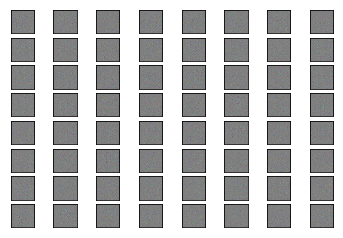

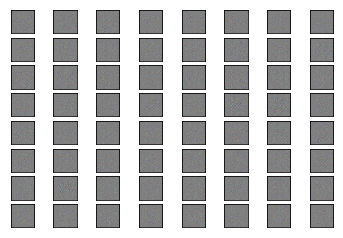

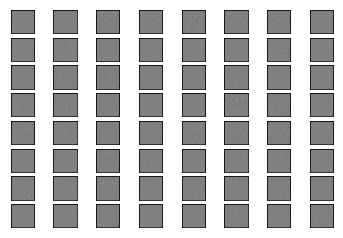

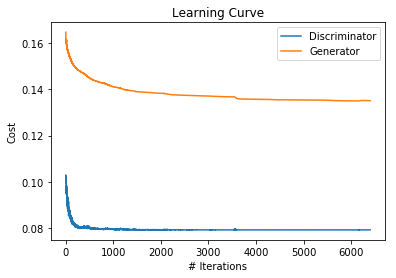

In [9]:
toRestore = False
restorePath = "../models/DCGAN/lsgan.ckpt" if toRestore else None
epochs = 5

discriminator_lossHistory, generator_lossHistory = ls_gan.train(fileDir=directory, epochs = epochs, saveModel = True,
                                                                    k = 1,  restorePath=restorePath, monitor=2)

# -------- Plot Learning Curve --------
plt.figure()
plt.title('Learning Curve')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.plot(discriminator_lossHistory, label="Discriminator")
plt.plot(generator_lossHistory, label="Generator")
plt.legend(loc = 'best')
plt.savefig('../figure/LSGAN/LearningCurve.png')

In [10]:
saver = tf.train.Saver()
save_path = saver.save(ls_gan.sess, "../models/LSGAN/lsgan_finished.ckpt")
print("  * Model saved in path: %s" % save_path)

  * Model saved in path: ../models/LSGAN/lsgan_finished.ckpt


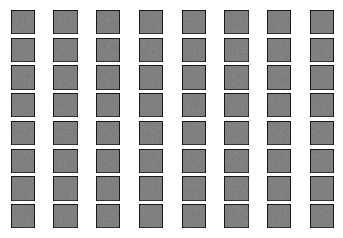

In [11]:
#
## ---------- Fake Images ----------
#

# z = np.random.normal(0, 1, size=(dc_gan.numGenerates, z_dim))
# # z = np.random.uniform(-5, 5, size=(batch_size, z_dim))
# feed_dict_test = {dc_gan.lattenCode : z }
# imgs = dc_gan.sess.run(dc_gan.fake_images, feed_dict=feed_dict_test)
imgs = ls_gan.generateFakeImages(ls_gan.numGenerates)
plotImages(imgs, savePath = '../figure/LSGAN/generate.png')